In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata as ad 

from scipy.stats import spearmanr

import xgboost as xgb 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn import svm

from tqdm import tqdm 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path

from config import FDIR_EXTERNAL, FDIR_RAW, FDIR_PROCESSED, FDIR_INTEMEDIATE

In [3]:
fdir_raw = FDIR_RAW
fdir_intermediate = FDIR_INTEMEDIATE
fdir_processed = FDIR_PROCESSED / 'sex'
fdir_external = FDIR_EXTERNAL

ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
# organ = "BRAIN1"
# organ = 'CAGE.HEART'

# 
sex = 'male'
sex = 'female'

n_opt_features = {
    "HEART": {
        "male": 9,
        "female": 11
    }, 
    "BRAIN0": {
        "male": 7,
        "female": 7
    }, 
    "BRAIN1": {
        "male": 17,
        "female": 8
    }, 
}


In [4]:
# adata = ad.read_h5ad(fdir_intermediate/f'{organ.upper()}.raw.h5ad')
adata = ad.read_h5ad(fdir_processed / f'{organ.upper()}.preprocessed.sex.h5ad')

adata.obs['age'] = adata.obs['Age']

adata = adata[adata.obs['age'].notna()]

adata.var_names = "tr_" + adata.var_names

adata_male = adata[adata.obs['sex'] == "male"]
adata_female = adata[adata.obs['sex'] == "female"]
# adata_both = adata.copy()
adata_female


View of AnnData object with n_obs × n_vars = 11 × 28445
    obs: 'Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cardiac_chamber', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'health_state', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sex', 'source_name', 'SRA Study', 'tissue', 'age'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    varm: 'autosomes', 'chr_aX', 'chr_aXY', 'chr_aY'
    layers: 'raw'

In [5]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

rhos = []
pvalues = []

for i in tqdm(range(adata_male.n_vars)):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
# for i in tqdm(range(adata_female.n_vars)):
    rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

rhos_male_nonan_ids = np.argwhere(~np.isnan(rhos_male)).ravel()
rhos_female_nonan_ids = np.argwhere(~np.isnan(rhos_female)).ravel()


for i in tqdm(range(adata.n_vars)):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(adata.X[:, i], adata.obs['age'].values)
    rhos.append(rho)
    pvalues.append(pvalue)
    
rhos = np.array(rhos)
rhos_nonan_ids  = np.argwhere(~np.isnan(rhos)).ravel()

  1%|          | 146/28445 [00:00<00:58, 483.01it/s]/tmp/ipykernel_396174/730353613.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
  4%|▍         | 1184/28445 [00:02<00:56, 479.14it/s]/tmp/ipykernel_396174/730353613.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
100%|██████████| 28445/28445 [00:30<00:00, 921.78it/s] 


In [6]:
adata_male.varm['rho'] = rhos_male
adata_female.varm['rho'] = rhos_female
adata.varm['rho'] = np.array(rhos)

adata_male.varm['pvalue'] = np.array(pvalues_male)
adata_female.varm['pvalue'] = np.array(pvalues_female)
adata.varm['pvalue'] = np.array(pvalues)

adata_male_nona = adata_male[:, rhos_male_nonan_ids].copy()
adata_female_nona = adata_female[:, rhos_female_nonan_ids].copy()
adata_nona = adata[:, rhos_nonan_ids].copy()

adata_eval = adata.copy()

/tmp/ipykernel_396174/1010159846.py:1: ImplicitModificationWarning: Setting element `.varm['rho']` of view, initializing view as actual.
  adata_male.varm['rho'] = rhos_male
/tmp/ipykernel_396174/1010159846.py:2: ImplicitModificationWarning: Setting element `.varm['rho']` of view, initializing view as actual.
  adata_female.varm['rho'] = rhos_female


In [7]:
#! BY R VALUE

datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

transcripts_dict = {
    "Both": [],
    "Male": [],
    "Female": []        
}


for key, dataset in datasets.items(): 

    unsignificant_corr_ids = np.argwhere(dataset.varm['pvalue'] > 0.05)

    rhos_ = np.array(dataset.varm['rho'])
    rhos_[unsignificant_corr_ids] = 0
    rhos_[np.argwhere(dataset.X.mean(axis=0) == 0)] = 0


    corr_threshold = 0.96
    corr_threshold = 0.5
    # corr_threshold = 0.4

    if np.abs(rhos_).max() > corr_threshold:
        
        sorted_corr_border = np.argwhere(np.sort(np.abs(rhos_))[::-1] > corr_threshold).max()
        sorted_corr_ids = np.argsort(np.abs(rhos_))[::-1][:sorted_corr_border]
    else:
        sorted_corr_ids = []

    transcripts_dict[key] = dataset.var.index[sorted_corr_ids]
transcripts_dict

{'Both': Index(['tr_ENST00000426161.8', 'tr_ENST00000508608.6', 'tr_MSTRG.17989.3',
        'tr_MSTRG.5258.13', 'tr_MSTRG.29444.5', 'tr_MSTRG.15240.43',
        'tr_MSTRG.27889.38', 'tr_MSTRG.33930.22', 'tr_MSTRG.13988.4',
        'tr_MSTRG.5168.4',
        ...
        'tr_MSTRG.34761.6', 'tr_ENST00000393962.6', 'tr_ENST00000338231.9',
        'tr_ENST00000335090.6', 'tr_ENST00000589508.1', 'tr_ENST00000445265.6',
        'tr_ENST00000469811.1', 'tr_MSTRG.28163.2', 'tr_ENST00000627450.2',
        'tr_ENST00000431816.6'],
       dtype='object', length=1092),
 'Male': Index(['tr_MSTRG.13769.10', 'tr_ENST00000666481.1', 'tr_MSTRG.13774.10',
        'tr_MSTRG.27792.20', 'tr_MSTRG.28898.5', 'tr_MSTRG.8132.15',
        'tr_MSTRG.1540.1', 'tr_ENST00000508608.6', 'tr_MSTRG.29296.78',
        'tr_MSTRG.18991.11',
        ...
        'tr_ENST00000576271.1', 'tr_ENST00000522703.1', 'tr_ENST00000526218.5',
        'tr_MSTRG.24493.1', 'tr_ENST00000471238.5', 'tr_ENST00000588734.5',
        'tr_MSTR

In [44]:
#! BY SEURAT VARIABLE IMPORTANCE

# flavor = 'cell_ranger'
flavor = 'seurat_v3_paper'
flavor = 'seurat_v3'
# flavor = 'seurat'

n_top_genes = 1000

sc.pp.highly_variable_genes(adata_nona, n_top_genes=n_top_genes, flavor=flavor)
# sc.pl.highly_variable_genes(adata_nona,log=True)

sc.pp.highly_variable_genes(adata_male_nona, n_top_genes=n_top_genes, flavor=flavor)
# sc.pl.highly_variable_genes(adata_male_nona,log=True)

sc.pp.highly_variable_genes(adata_female_nona, n_top_genes=n_top_genes, flavor=flavor)
# sc.pl.highly_variable_genes(adata_female_nona,log=True)


if flavor == 'seurat':
    transcripts_all = adata_nona.var['dispersions_norm'].loc[adata_nona.var['highly_variable']].sort_values()[::-1].index
    transcripts_m = adata_male_nona.var['dispersions_norm'].loc[adata_male_nona.var['highly_variable']].sort_values()[::-1].index
    transcripts_f = adata_female_nona.var['dispersions_norm'].loc[adata_female_nona.var['highly_variable']].sort_values()[::-1].index

else:
    transcripts_all = adata_nona.var['highly_variable_rank'][adata_nona.var['highly_variable']].sort_values().index
    transcripts_m = adata_male_nona.var['highly_variable_rank'][adata_male_nona.var['highly_variable']].sort_values().index
    transcripts_f = adata_female_nona.var['highly_variable_rank'][adata_female_nona.var['highly_variable']].sort_values().index

datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

transcripts_dict = {
    "Both": transcripts_all,
    "Male": transcripts_m,
    "Female": transcripts_f        
}

cv = LeaveOneOut()


for key, dataset in datasets.items(): 
    transcripts = transcripts_dict[key]
    
    ranks = np.zeros(n_top_genes)
    X = dataset[:, transcripts].X
    y = dataset.obs['age'].values
    
    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]
        
        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
        # model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
        model = svm.SVR(kernel="linear")
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        # if i > 1:
        #     break
        ranks += np.abs(model.coef_).ravel().tolist()
        # ranks += model.feature_importances_
        
    transcripts_dict[key] = transcripts[ranks.argsort()[::-1][:100]]


/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
20it [00:00, 1274.65it/s]
9it [00:00, 1554.21it/s]
11it [00:00, 1081.16it/s]


In [45]:
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler


datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

scores = {
    'r2': {},
    'RMSE': {}
} 

for key, dataset in datasets.items():
    rmses = []
    r2_scores = []

    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()
    
    transcripts = transcripts_dict[key]
    
    for n_features in tqdm(range(1, 30)):

        X = dataset[:, transcripts[:n_features]].X
        y = dataset.obs['age'].values

        # print(X.shape)
        print(f"{n_features=}")
        
        preds = []
        vals  = []
        gls_preds = []
        
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]
            
            # train_scaler = RobustScaler().fit(X_train)
            # test_scaler = RobustScaler().fit(X_test)
            # X_train = train_scaler.transform(X_train)
            # X_test = test_scaler.transform(X_test)
            

            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test
            
            model = svm.SVR(kernel='linear')
            # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
            # model = LinearRegression()
            # model = Ridge()
            # model = xgb.XGBRegressor(n_estimators=300, max_depth=4, )
            # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
            #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
            model.fit(X_train_, y_train_)
            pred = model.predict(X_val)


            preds.extend(pred)
            vals.extend(y_val)

        rmses.append(RMSE(np.ravel(preds), np.ravel(vals)))
        r2_scores.append(r2_score(np.ravel(vals), np.ravel(preds)))
        
        print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
        print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
        
    scores['RMSE'][key] = rmses
    scores['r2'][key] = r2_scores

    print("-"*20)


# model.coef_

  0%|          | 0/29 [00:00<?, ?it/s]

n_features=1


20it [00:00, 1762.72it/s]


RMSE:  4.669544286066732
R2:  0.0660822854893045
n_features=2


20it [00:00, 1611.37it/s]


RMSE:  4.988246240826313
R2:  -0.06575010425603756
n_features=3


20it [00:00, 1717.32it/s]


RMSE:  4.678914066269554
R2:  0.062330577597811576
n_features=4


20it [00:00, 1352.37it/s]


RMSE:  2.9777361653787984
R2:  0.620220037665496
n_features=5


20it [00:00, 1638.18it/s]
 17%|█▋        | 5/29 [00:00<00:00, 43.51it/s]

RMSE:  3.3022912959388107
R2:  0.5329209635621275
n_features=6


20it [00:00, 1461.71it/s]


RMSE:  3.464171210124903
R2:  0.48600568912910436
n_features=7


20it [00:00, 1528.06it/s]


RMSE:  3.493705370412525
R2:  0.47720410256989754
n_features=8


20it [00:00, 1452.77it/s]


RMSE:  3.654377153486797
R2:  0.4280127474065205
n_features=9


20it [00:00, 1402.94it/s]


RMSE:  4.767908947347282
R2:  0.02632163057311232
n_features=10


20it [00:00, 1499.89it/s]
 34%|███▍      | 10/29 [00:00<00:00, 42.37it/s]

RMSE:  4.968969453935483
R2:  -0.057528961736541095
n_features=11


20it [00:00, 1404.56it/s]


RMSE:  5.060484059503729
R2:  -0.09684115714707486
n_features=12


20it [00:00, 1255.89it/s]


RMSE:  5.329643574737056
R2:  -0.21662279189360678
n_features=13


20it [00:00, 1170.71it/s]


RMSE:  6.277847982846273
R2:  -0.6880340634212236
n_features=14


20it [00:00, 1251.94it/s]


RMSE:  6.746253559267112
R2:  -0.9493280687835601
n_features=15


20it [00:00, 1228.78it/s]
 52%|█████▏    | 15/29 [00:00<00:00, 40.59it/s]

RMSE:  6.791049782077661
R2:  -0.9753017300634776
n_features=16


20it [00:00, 1016.64it/s]


RMSE:  4.633438312890313
R2:  0.0804689752924369
n_features=17


20it [00:00, 1097.90it/s]


RMSE:  5.427994730622637
R2:  -0.2619392566941692
n_features=18


20it [00:00, 801.81it/s]


RMSE:  1.0534837866807627
R2:  0.9524647997087808
n_features=19


20it [00:00, 725.87it/s]


RMSE:  2.055217921810803
R2:  0.8190846683314138
n_features=20


20it [00:00, 1164.68it/s]
 69%|██████▉   | 20/29 [00:00<00:00, 35.94it/s]

RMSE:  1.8560172915155964
R2:  0.852455287015531
n_features=21


20it [00:00, 1272.62it/s]


RMSE:  2.273998652705588
R2:  0.7785171914548954
n_features=22


20it [00:00, 1239.27it/s]


RMSE:  1.7428957360018074
R2:  0.869892470432668
n_features=23


20it [00:00, 1429.31it/s]


RMSE:  1.8137430484807908
R2:  0.8590999530608249
n_features=24


20it [00:00, 1501.16it/s]


RMSE:  2.438384615892286
R2:  0.7453380646741548
n_features=25


20it [00:00, 1473.52it/s]
 86%|████████▌ | 25/29 [00:00<00:00, 37.62it/s]

RMSE:  2.8554740769664604
R2:  0.650766368809189
n_features=26


20it [00:00, 1512.63it/s]


RMSE:  2.62586888372901
R2:  0.7046712755311602
n_features=27


20it [00:00, 1504.90it/s]


RMSE:  2.4493785147090015
R2:  0.7430365089059611
n_features=28


20it [00:00, 1548.40it/s]


RMSE:  2.427375748310237
R2:  0.7476323793346319
n_features=29


20it [00:00, 1157.51it/s]
100%|██████████| 29/29 [00:00<00:00, 38.50it/s]


RMSE:  1.9258920405707094
R2:  0.8411367319013338
--------------------


  0%|          | 0/29 [00:00<?, ?it/s]

n_features=1


9it [00:00, 1581.43it/s]


RMSE:  3.2601334866799867
R2:  0.2028647236770844
n_features=2


9it [00:00, 1383.04it/s]


RMSE:  3.2253298542371205
R2:  0.21979354985250654
n_features=3


9it [00:00, 1548.16it/s]


RMSE:  3.452499479049996
R2:  0.106018551036963
n_features=4


9it [00:00, 1522.00it/s]


RMSE:  3.0457998891558886
R2:  0.30423272764134823
n_features=5


9it [00:00, 1375.53it/s]


RMSE:  2.828712191159665
R2:  0.39987905046885175
n_features=6


9it [00:00, 888.67it/s]
 21%|██        | 6/29 [00:00<00:00, 50.48it/s]

RMSE:  3.2844821424192343
R2:  0.1909132792096867
n_features=7


9it [00:00, 710.24it/s]


RMSE:  3.672440646083387
R2:  -0.011511522425402543
n_features=8


9it [00:00, 1412.33it/s]


RMSE:  1.5025872945078036
R2:  0.830667356678779
n_features=9


9it [00:00, 1548.98it/s]


RMSE:  1.6043096296722839
R2:  0.8069642959105585
n_features=10


9it [00:00, 1474.62it/s]

RMSE:  1.8664616078216691
R2:  0.7387240799895812
n_features=11



9it [00:00, 1422.87it/s]

RMSE:  2.144778486861678
R2:  0.6549943931721498


n_features=12


9it [00:00, 1626.12it/s]
 41%|████▏     | 12/29 [00:00<00:00, 51.20it/s]

RMSE:  2.187405298010698
R2:  0.6411443546676047
n_features=13


9it [00:00, 1489.57it/s]

RMSE:  2.07351672912245
R2:  0.6775396280537003


n_features=14


9it [00:00, 1568.42it/s]


RMSE:  2.03058262276757
R2:  0.6907550659085783
n_features=15


9it [00:00, 1430.85it/s]


RMSE:  1.9547371575279155
R2:  0.7134251983734764
n_features=16


9it [00:00, 1600.34it/s]

RMSE: 

 0.8724210174241892
R2:  0.9429161176267407
n_features=17


9it [00:00, 1546.26it/s]

RMSE:  0.8690455193754398
R2:  0.9433569913940104


n_features=18


9it [00:00, 1578.19it/s]
 62%|██████▏   | 18/29 [00:00<00:00, 54.82it/s]

RMSE:  0.8931318653648055
R2:  0.9401736603302487
n_features=19


9it [00:00, 1649.86it/s]


RMSE:  0.8156712612462438
R2:  0.9501010295182721
n_features=20


9it [00:00, 1665.73it/s]


RMSE:  1.0526930995254227
R2:  0.9168877928658669
n_features=21


9it [00:00, 1627.80it/s]


RMSE:  1.0645195317526996
R2:  0.915009862488776
n_features=22


9it [00:00, 1682.06it/s]


RMSE:  1.2386011445961356
R2:  0.8849400403453858
n_features=23


9it [00:00, 1369.10it/s]


RMSE:  1.307624212812751
R2:  0.8717589188549375
n_features=24


9it [00:00, 1273.96it/s]
 83%|████████▎ | 24/29 [00:00<00:00, 56.59it/s]

RMSE:  1.3118075522095474
R2:  0.8709370709474497
n_features=25


9it [00:00, 1511.22it/s]


RMSE:  1.3075172485507554
R2:  0.8717798983556697
n_features=26


9it [00:00, 1888.29it/s]


RMSE:  1.271991641167271
R2:  0.8786527948600444
n_features=27


9it [00:00, 1646.40it/s]


RMSE:  1.2893119994364381
R2:  0.8753255926081911
n_features=28


9it [00:00, 1606.12it/s]

RMSE:  1.3387321187839336
R2:  0.865584723560221


n_features=29


9it [00:00, 1686.87it/s]
100%|██████████| 29/29 [00:00<00:00, 45.50it/s]

RMSE:  1.306014027495077
R2:  0.8720745519989567


--------------------


  0%|          | 0/29 [00:00<?, ?it/s]

n_features=1


11it [00:00, 1706.96it/s]


RMSE:  3.019496060263857
R2:  0.6739952330343311
n_features=2


11it [00:00, 1620.79it/s]


RMSE:  3.4167534745207244
R2:  0.58257129994575
n_features=3


11it [00:00, 1655.39it/s]


RMSE:  2.23804401359228
R2:  0.8209013706205894
n_features=4


11it [00:00, 1652.66it/s]


RMSE:  2.466950593265995
R2:  0.7823914678535848
n_features=5


11it [00:00, 1702.61it/s]


RMSE:  3.4516003896730014
R2:  0.5740133051864986
n_features=6


11it [00:00, 1599.94it/s]
 21%|██        | 6/29 [00:00<00:00, 59.57it/s]

RMSE:  4.130218364096615
R2:  0.3900404397311964
n_features=7


11it [00:00, 1570.42it/s]


RMSE:  4.1721087234577885
R2:  0.3776047768195444
n_features=8


11it [00:00, 1629.43it/s]


RMSE:  4.343816306047595
R2:  0.3253198722863826
n_features=9


11it [00:00, 1606.96it/s]


RMSE:  3.988137561022113
R2:  0.43128422403017597
n_features=10


11it [00:00, 1610.88it/s]


RMSE:  3.864751473655766
R2:  0.4659300300449012
n_features=11


11it [00:00, 1297.38it/s]


RMSE:  3.7816621113171425
R2:  0.48864740921253924
n_features=12


11it [00:00, 1199.81it/s]
 41%|████▏     | 12/29 [00:00<00:00, 50.94it/s]

RMSE:  3.941070386485594
R2:  0.4446287438713715
n_features=13


11it [00:00, 820.25it/s]


RMSE:  4.387161006436644
R2:  0.31178812492193253
n_features=14


11it [00:00, 1018.91it/s]


RMSE:  4.434727635223446
R2:  0.2967837136429198
n_features=15


11it [00:00, 1326.20it/s]


RMSE:  5.174929069542243
R2:  0.042444800280734496
n_features=16


11it [00:00, 1497.97it/s]


RMSE:  2.8919849032651195
R2:  0.7009477605300483
n_features=17


11it [00:00, 1526.31it/s]


RMSE:  3.428839571791379
R2:  0.5796129320629488
n_features=18


11it [00:00, 1588.81it/s]
 62%|██████▏   | 18/29 [00:00<00:00, 46.87it/s]

RMSE:  3.034925722826732
R2:  0.6706549434656859
n_features=19


11it [00:00, 1646.47it/s]


RMSE:  3.0286656196595194
R2:  0.6720122140305504
n_features=20


11it [00:00, 1728.77it/s]

RMSE:  2.0413713447482063
R2:  0.8509956167180109


n_features=21


11it [00:00, 1213.37it/s]

RMSE:  2.3274078290119444
R2:  0.8063132117292917


n_features=22


11it [00:00, 1563.08it/s]


RMSE:  2.311815648928348
R2:  0.8088996799792465
n_features=23


11it [00:00, 1582.59it/s]
 79%|███████▉  | 23/29 [00:00<00:00, 46.97it/s]

RMSE:  2.120912525426724
R2:  0.83915760555498
n_features=24


11it [00:00, 1330.18it/s]


RMSE:  1.8488273649182707
R2:  0.8777784640491292
n_features=25


11it [00:00, 1137.93it/s]


RMSE:  1.8118449010239572
R2:  0.8826192034901453
n_features=26


11it [00:00, 1430.08it/s]


RMSE:  1.732122205311093
R2:  0.8927216526507259
n_features=27


11it [00:00, 1671.22it/s]


RMSE:  1.6652006116326248
R2:  0.9008510454152536
n_features=28


11it [00:00, 1618.29it/s]
 97%|█████████▋| 28/29 [00:00<00:00, 46.53it/s]

RMSE:  1.710816710077336
R2:  0.8953445178271098
n_features=29


11it [00:00, 1710.37it/s]
100%|██████████| 29/29 [00:00<00:00, 48.05it/s]

RMSE:  1.6037197828007785
R2:  0.9080372416810474
--------------------


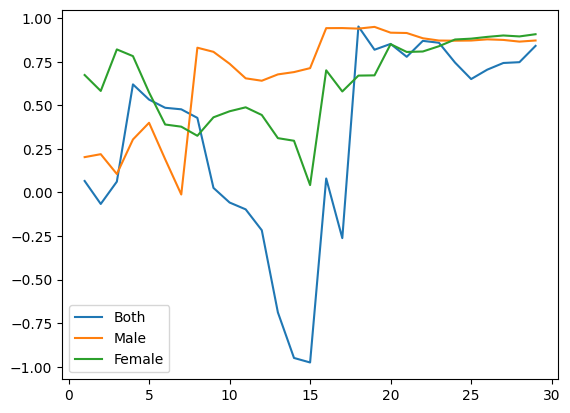

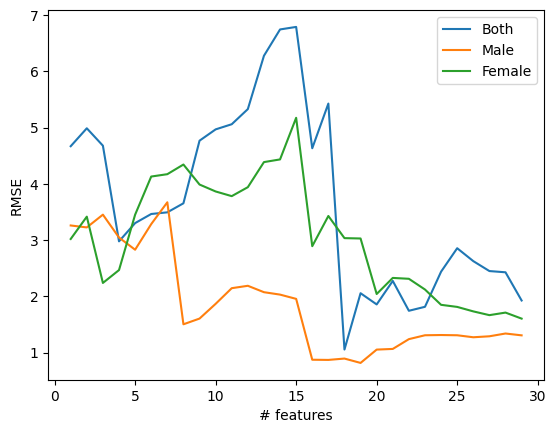

In [46]:
plt.figure()
for key, value in scores['r2'].items():
    plt.plot(range(1,30), value, label=key)
plt.legend()
plt.show()

plt.figure()
for key, value in scores['RMSE'].items():
    plt.plot(range(1,30), value, label=key)
plt.xlabel("# features")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [47]:
n_features = {
    'Both': 4,
    'Male': 5,
    'Female': 3
}


results = {}

for key, dataset in datasets.items(): 
    rmses = []
    r2_scores = []
    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()
    
    transcripts = transcripts_dict[key]

    X = dataset[:, transcripts[:n_features[key]]].X
    y = dataset.obs['age'].values

    preds = np.zeros(len(y))
    vals  = np.zeros(len(y))

    for i, (train, val) in enumerate(cv.split(X, y)):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]
        
        
        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
        # model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
        model = svm.SVR(kernel='linear')
        # model = Ridge()
        
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        preds[val] = pred
        vals[val] = y_val
        
        # preds.extend(pred)
        # vals.extend(y_val)
        
    results[key] = {}
    results[key]['preds'] = preds
    results[key]['vals'] = vals

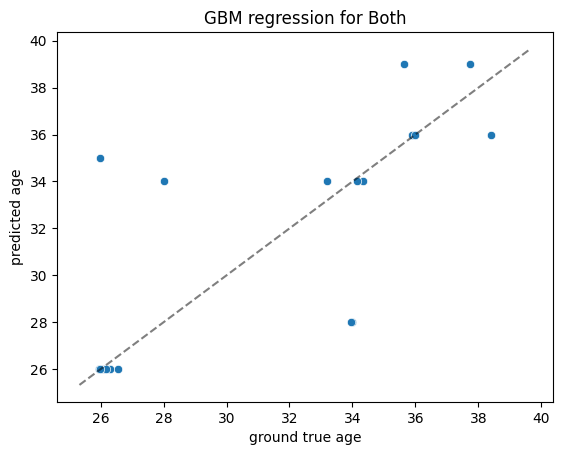

3.2293578125883595


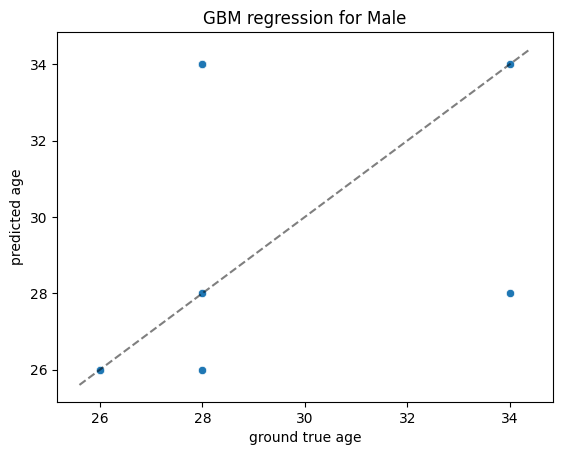

4.055119087016233


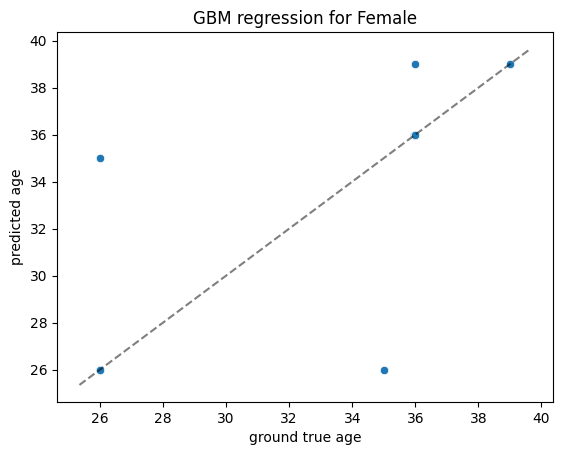

3.9427160605057003


In [39]:
for key, val in results.items():

    g = sns.scatterplot(
        y=np.array(val['vals']).ravel(), 
        x=np.array(val['preds']).ravel(), 
        # hue=datasets[key].obs['chamber']
        )
    g.set_title(f"GBM regression for {key}")
    g.set_ylabel("predicted age")
    g.set_xlabel("ground true age")

    lims = [
        np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
        np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
    ]

    # sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    g.plot(lims, lims, '--', color='k', alpha=0.5)
    
    plt.show()
    
    print(RMSE(np.ravel(val['vals']), np.ravel(val['preds'])))
